# Musicboard API Extraction

This notebook demonstrates how to fetch data from a website using a REST API. 
We will walk through the process of sending an HTTP request to an API 
handling the response, and converting the data into a usable format.

But before we dive straight into getting information regarding getting data from Musicboard's API, I feel like it's important to discuss a little more about APIs and data extraction.

## APIs, Data Extraction

APIs (Application Programming Interfaces) are sets of rules and protocols that allow different software applications to communicate with each other. They serve as a bridge that enables one system to request and exchange data or services from another system without needing to understand its internal workings. They're used in many websites to allow for getting structured data easily, and allow for scalability and automation across many different platforms. In the field of data science, they are especially useful because they are an easy gateway to vast amounts of data such as weather information (OpenWeather, NOAA), stocks/financial information (Tiingo, Alpha Vantage), among many, *many* other applications.

### A Quick Note on Legality

I want to leave a disclaimer on this point because training data gathered from outside resources is in both a legal and moral grey area. The primary concern stems from collecting large amounts of personal or copyrighted information to train ML models or improve a product. Some websites are more open to using their data for CS purposes (e.g. Wikipedia). In a recent high-profile example, OpenAI is being sued from multiple angles for the data they collected to train their models like ChatGPT and DALL-E. There's a reason why websites like Twitter and Reddit recently started to severely restrict their APIs (even if in doing so kneecapped research), and even Spotify added a little clause in their API saying that their data "may not be used to train machine learning or AI model".

Luckily, as college students developing personal projects, the probability a company will come after you for using their data is extremely small, and far less than a company using their data for commercial purposes. That being said, to avoid any potential implications, I strongly recommend you to **never upload any data of any kind to your Github portfolio**. This applies for any data pulled from Musicboard, APIs/Webscraping from other sources, or even datasets from Kaggle. The reason for this is to reduce the risk of getting contacted by these companies, and to maximize the space you have in your repo (recall that Github is more-so a space to upload code and relevant files, and not a file storage space like Google Drive, hence the file size limits is ~100MB). You can store any relevant data files while not uploading them to Github by using a .gitignore file.

### Getting Started

Musicboard's API is built off of the Django REST Framework. For this tutotial, you do need to have prior knowledge of Django.

First, make sure that you have the necessary libraries installed. We will continue to use the NumPy and Pandas libraries, but we will also introduce two new libraries for this week. For REST API requests, we'll use the `requests` and `json` libraries.
```

In [31]:
# You do not need to run the command below if you already have requests installed.
# You should not need to install the json library, as it's a standard Python library.
!pip install requests

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json

In any website, we use APIs to be able to retrieve information from servers and be able to display it on any device, whether it be a mobile app, a desktop website, or the browser on the display smart fridges at the Home Depot. For many websites (including Musicboard), we can see information being fetched from these APIs by their incoming network traffic, visible via your browser's Inspect Element/Developer Tools feature. You can find this by right clicking on (most) pages, or for the shortcut:
* **Windows Users:** Ctrl + Shift + I *OR* F12
* **Mac Users:** Cmd + Option + I (Chromium browsers + Firefox), *OR* Cmd + Option + C (Safari)
  * (if I got the mac commands wrong I apologize, I don't have a mac on me to verify this myself lol)

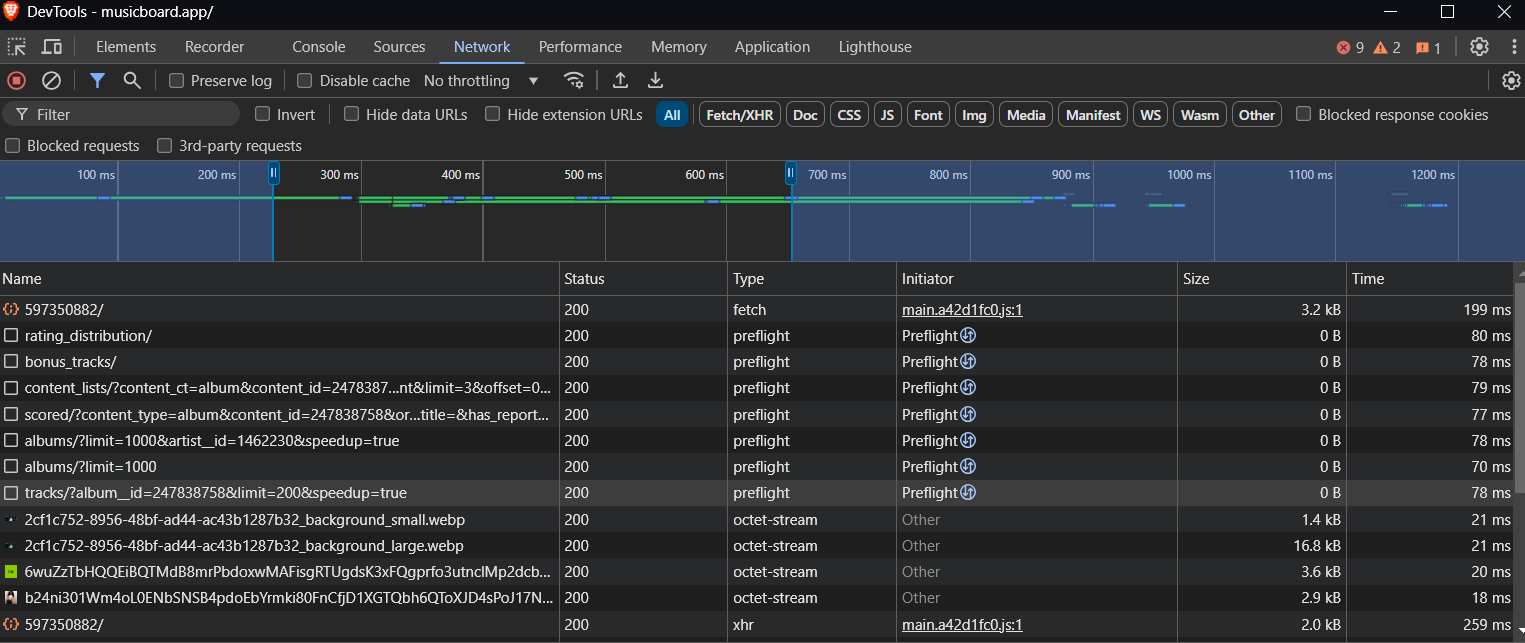

*Image: Sample Network Tab Example for a Musicpage on Musicboard.*

**NOTE:** Some APIs require authentication if you'd like to be able to get information from them, in the form of items like API keys, JWT, bearer tokens, etc. These are more common for larger platforms and makes obtaining data more difficult if you don't have that information

Let's get the ratings for an album! Let's search up for an album with a modest\* amount of ratings. Below, I am getting the ratings for an album *Bloom* by Beach House, screenshot of the webpage and network tab displayed below.

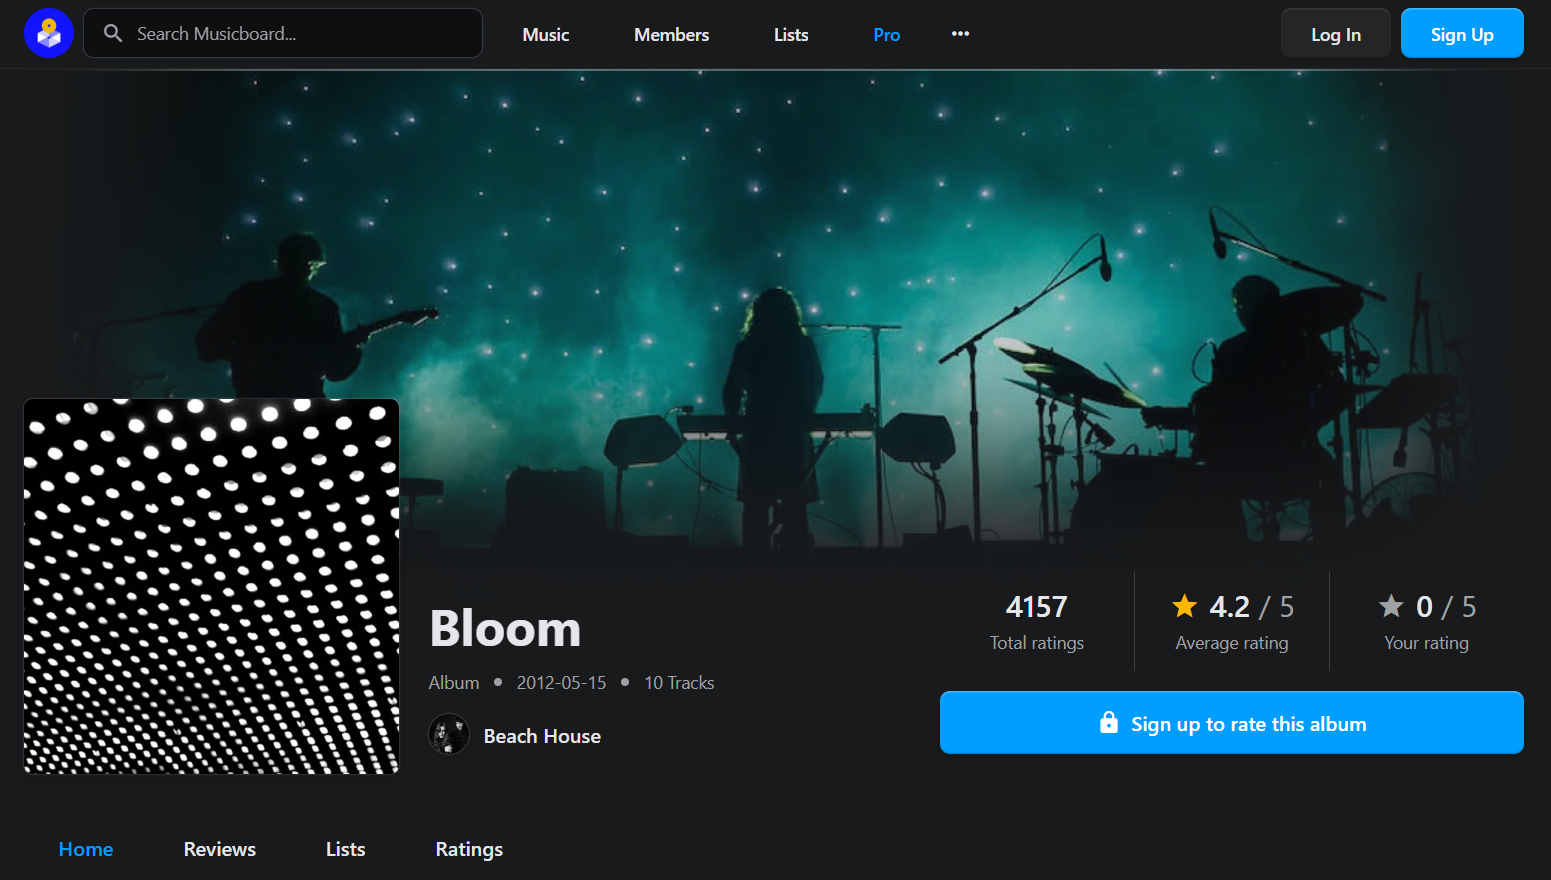

When we click on the "Ratings" tab for the album, and we filter our Network tab results to *only* get Fetch/XHR values, we can get useful info on the Musicboard API. The previous network tab screenshot demonstrated all incoming traffic, and that included stuff like JavaScript files, images, CSS files, and a bunch of other stuff that we realistically don't care about; for our API, what we care about most is seen in the "Fetch/XHR" section because that is where we can get text information and API calls. Below is a screenshot of some of the Fetch/XHR entities from just being on the page and seeing the home and ratings pages for the album; one of these API calls is highlighted and more info is shown as well.

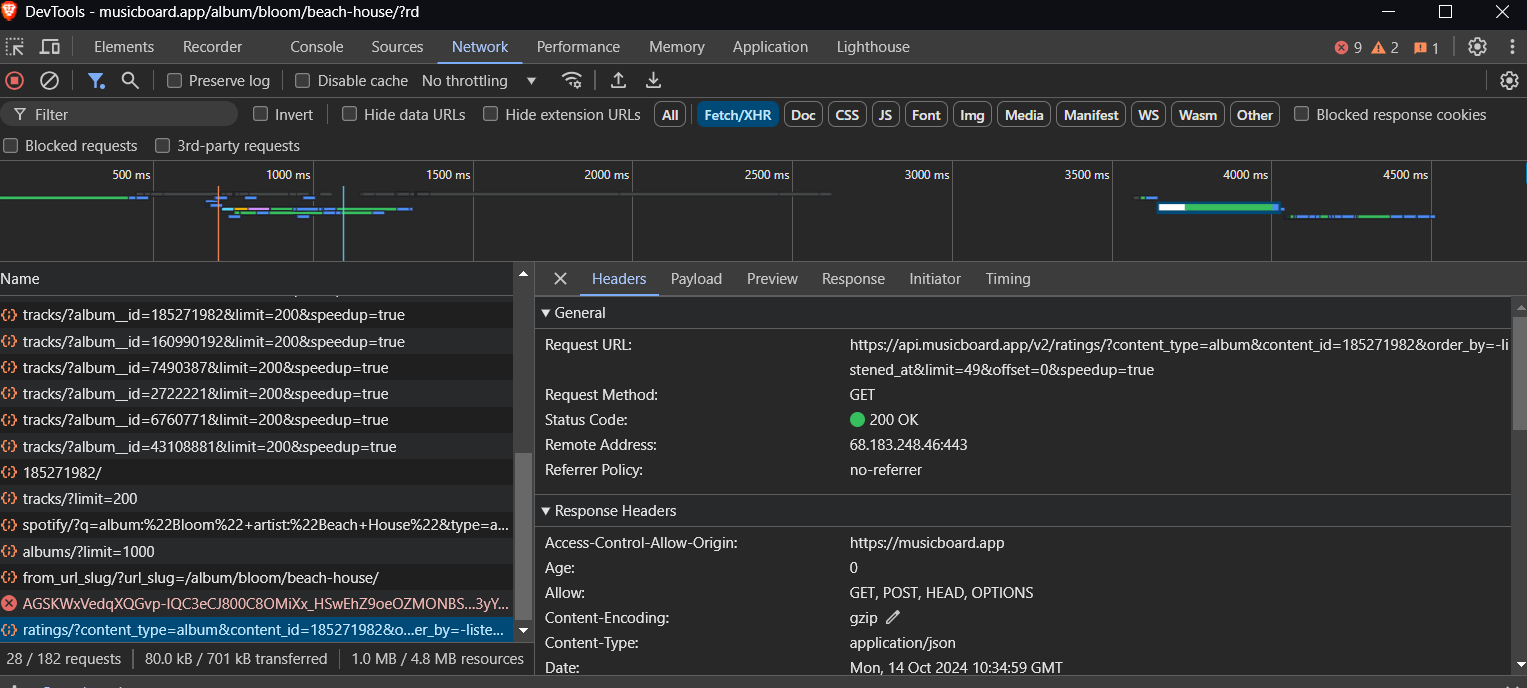

From the highlighted API call above, we can see there's now some more sub-groups that provide more information on the API call we highlighted. In the tab visible to us now, the *header*, we can see the exact URL link of the API, details like the response code (200 if information was retrieved successfully, 4XX or 5XX if something's gone wrong, etc.), and where we would see details on authorization if our API call was utilizing that (but in our case, we don't need to worry). We can see the exact information we received in the *response* tab; we can also get those exact same results by copy pasting the URL to a new tab.

\*There is an interesting quirk with the API for albums with a large number of ratings (typically >5000), but put a pin on that for now and don't forget it.

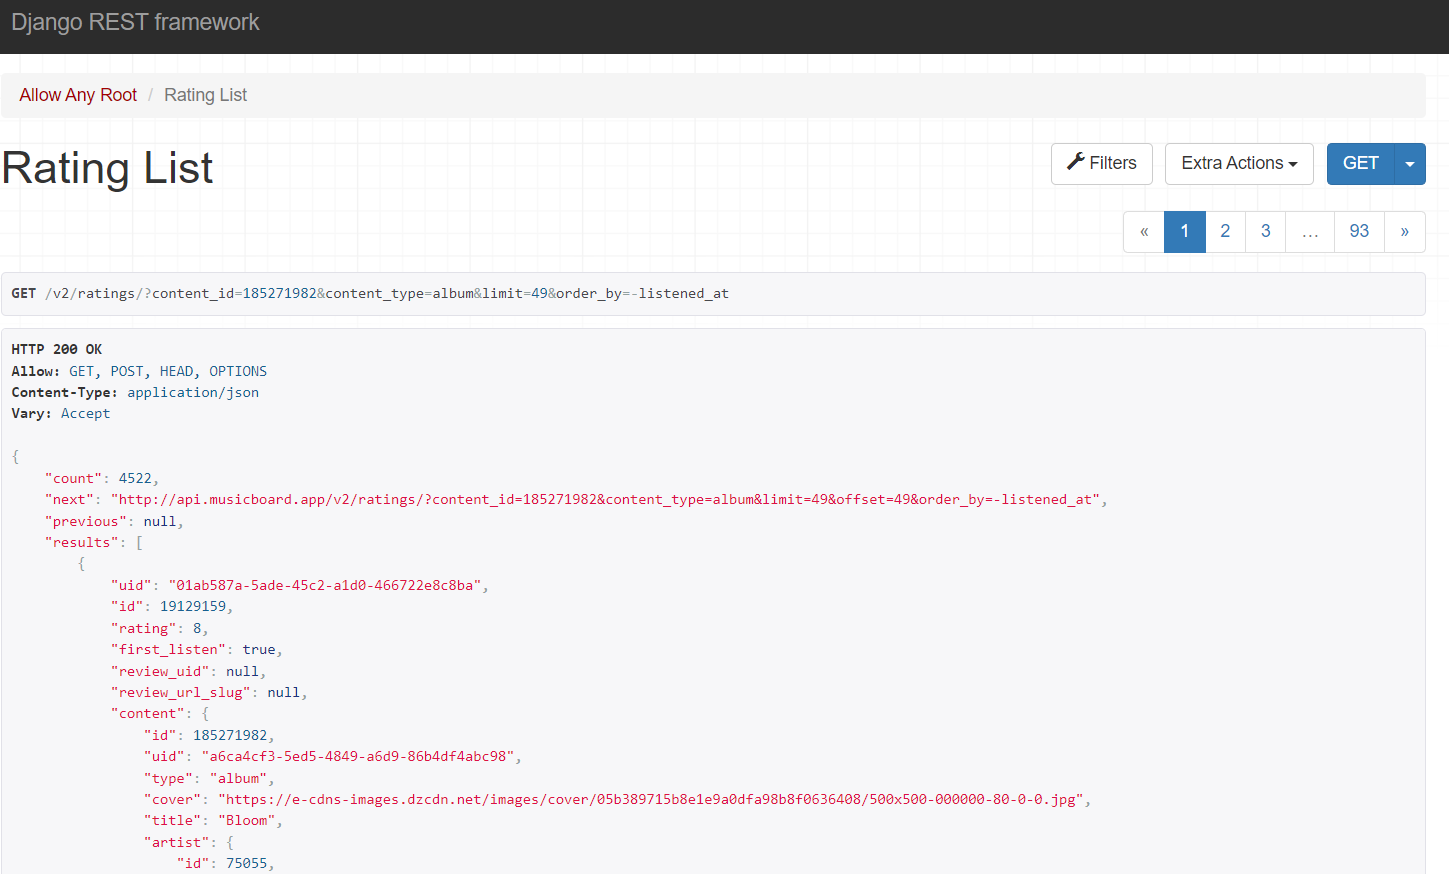

Here is what the API looks like if you follow the link. I did make one slight change by removing the *&speedup=true* at the end, just so we could see the 'count' value in our API. Here, we can see that our data is neatly formatted, thanks to our API being given to us in a JSON format! Though it's not immediately clear, this API call is still referring to *Bloom*, the album I showed off at the beginning of this markdown section. It's just that it's assigned the ID 185271982 in the backend. Here, we have access to all of the ratings left by users on this album, all 4522 ratings!

Let's go ahead and collect some ratings. I'll be using a slightly different album, but the extraction process for any album should be the same. Let's just get all of the ratings and find the average.

In [11]:
album_id = 69352202
url = f"https://api.musicboard.app/v2/ratings/?content_id={album_id}&content_type=album"
ratings = []
offset = 0
response = requests.get(url)
results = json.loads(response.text)
while (results != "Unable to communicate with server." and offset < results['count']):
    for entry in results['results']:
        if entry['rating']:
            ratings.append(entry['rating'])
    offset += 24
    if offset <= results['count']:
        response = requests.get(results['next'])
        results = json.loads(response.text)

print(len(ratings), sum(ratings)/len(ratings))

4900 8.671836734693878


Good stuff! For this album (*Imaginal Disk* by Magdalena Bay (btw this is a great album if you're into synthpop)), we can see that there have been 3078 ratings with an average rating of 8.72 out of 10! Note that the exact figures might be slightly different if you run this again in the future, but we're not so concerned with specifics here.

Let's take it a step further. Let's get some of the same information from the Netflix Prize. For the ratings themselves, let's get the users\*, the album IDs (in this case, just one album), the timestamp they rated the album, and their rating! Of course, when building the actual model, you're more than free to get more information to add to your model, either from the API (from the same ratings call or from another Musicboard API call, like albums info) or elsewhere (we'll cover this point later on).

\*Note: Due to privacy laws, it is strongly *not* recommended to store personally identifiable information in whatever application you're developing. In this case, instead of getting the usernames, we'll be getting users by their user ID, represented by a GUID. If you want to be extra secure, you could also create your own form of identification for these users (e.g. hashing your own GUID), but let's just keep it simple and get the already existing GUID.

In [10]:
album_id = 248043684
url = f"https://api.musicboard.app/v2/ratings/?content_id={album_id}&content_type=album"
creators = []
ratings = []
timestamps = []
offset = 0
response = requests.get(url)
results = json.loads(response.text)
while (offset < results['count']):
    for entry in results['results']:
        if entry['rating']:
            ratings.append(entry['rating'])
            creators.append(entry['creator']['uid'])
            timestamps.append(entry['created_at'])
    offset += 24
    print(offset)
    if results['next']:
        response = requests.get(results['next'])
        results = json.loads(response.text)
    else:
        break

df = pd.DataFrame({
    'User': creators,
    'Album': album_id,
    'Rating': ratings,
    'Timestamp': timestamps
})

display(df)

24
48
72
96
120
144


KeyboardInterrupt: 

OK, good stuff!

However, I do want to point out a slight problem... this does include multiple ratings from the same user. To show this, keep in mind that we have a little over 3k ratings (as of writing this markdown), but when we run the command below to count number of unique users...

In [150]:
len(pd.unique(df['User']))

2946

...we see we have slightly *less* than 3k users. It's a dumb feature from Musicboard (I guess they have it so people could show their opinions have changed over time), but in my model, I want to have only one rating per user. After all, our rec system will be confused if we see multiple ratings! You can choose however you'd like to accomodate these ratings - choose the first rating, take the mean - but I want to get just the most recent rating, and remove all other ratings. This is one instance of data cleaning from our acquired data! Even though we got our data pretty nicely, we still need to ensure that our data is clean enough so that our models can give us good results! If we have bad, unclean data, we're going to get bad results; garbage in, garbage out.

In [152]:
df = df.loc[df.groupby('User')['Timestamp'].idxmax()]
display(df.head())
df.info()

User      Album  Rating  \
731   001113ff-a269-4a4e-a29e-a56fe6b8dda0  248043684       8   
2255  0015017d-6280-44e2-b484-a015b13098ad  248043684       9   
2416  002851ee-13ed-4458-9713-f4d79f711650  248043684       7   
796   00416d2f-2e56-46dc-b2d6-f421bf8ed4f9  248043684       3   
1140  0046b150-912d-42cf-bd00-c69852c0117b  248043684       8   

                        Timestamp  
731   2024-09-16T09:52:23.104065Z  
2255  2024-08-27T20:32:50.646941Z  
2416  2024-08-26T20:06:50.797810Z  
796   2024-09-14T21:38:58.649164Z  
1140  2024-09-08T21:36:28.079630Z

<class 'pandas.core.frame.DataFrame'>
Index: 2946 entries, 731 to 2465
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   User       2946 non-null   object
 1   Album      2946 non-null   int64 
 2   Rating     2946 non-null   int64 
 3   Timestamp  2946 non-null   object
dtypes: int64(2), object(2)
memory usage: 115.1+ KB


In [154]:
df[df['User'] == "ce671c46-db90-451f-b0b5-52b38a9009dd"]

User      Album  Rating  \
2  ce671c46-db90-451f-b0b5-52b38a9009dd  248043684       6   

                     Timestamp  
2  2024-10-10T20:14:49.455666Z

### 510?

oh hey here's that pin I was talking about from earlier you better not have forgotten about it

So, one thing that is interesting is that for albums that are really popular on Musicboard (normally more than 5000 ratings), you will run into a 510 error from the database. You can try this yourself: find a popular album (e.g. *IGOR* or *Abbey Road*), go to the API link, and try going to the last page of ratings - you can't! The reason for this is likely due to technical limitations on behalf of Musicboard - this is something that we, as data extractors, cannot change, and have to navigate around.

To illustrate this example in code form, I took the album ID for *brat* by Charli XCX (an album with some 15k ratings) and try running to get all ratings. In this case, the code will not crash because of the additional stipend I put in the while statement `results != "Unable to communicate with server." and `, but if you just kept the `offset < results['count']`, you *will* run into a crash.

In [160]:
album_id = 247838758
offset = 5001 # you can set this to like 5000 if you don't want to wait
url = f"https://api.musicboard.app/v2/ratings/?content_id={album_id}&content_type=album&offset={offset}"
creators = []
ratings = []
timestamps = []
response = requests.get(url)
results = json.loads(response.text)
while (results != "Unable to communicate with server." and offset < results['count']):
    # 
    for entry in results['results']:
        if entry['rating']:
            ratings.append(entry['rating'])
            creators.append(entry['creator']['uid'])
            timestamps.append(entry['created_at'])
    offset += 24
    if offset % 120 == 0 or offset > 5000:
        print(offset)
    if results['next']:
        response = requests.get(results['next'])
        results = json.loads(response.text)
    else:
        break

df = pd.DataFrame({
    'User': creators,
    'Album': album_id,
    'Rating': ratings,
    'Timestamp': timestamps
})

display(df)

5025
5049
5073


User      Album  Rating  \
0   8627c011-169c-47df-9a23-f0f5f4ebb1dc  247838758       9   
1   9d3a2629-2f8b-488d-9647-12f291c457f4  247838758       8   
2   aec3504f-b5e9-42e2-9928-8dfeb097ce5c  247838758      10   
3   3e6a0559-15e0-4266-8222-982d0660ad80  247838758       6   
4   b8e8e9d8-bf22-4c7f-93d0-5ac17fd94486  247838758       8   
..                                   ...        ...     ...   
63  bd301e68-b560-49eb-83c4-4d2757e06840  247838758       8   
64  d2fd5643-dedc-4c84-b4c5-48232f74a094  247838758       8   
65  850c39e0-5e37-4bf8-937d-fb5efab5a52e  247838758       6   
66  b120e8f1-61e5-4dfb-9e60-159463cb7275  247838758       7   
67  e0ffee70-e10e-4918-bf2a-62eadcfc29d1  247838758       8   

                      Timestamp  
0   2024-08-05T07:40:45.629419Z  
1   2024-08-05T07:31:22.032434Z  
2   2024-08-05T07:15:10.545949Z  
3   2024-08-05T06:23:47.643705Z  
4   2024-08-05T06:10:16.078744Z  
..                          ...  
63  2024-08-04T18:11:32.974043Z  
64  2024-08-04T18:08:57.570046Z  
65  2024-08-04T18:01:02.603218Z  
66  2024-08-04T17:59:46.640995Z  
67  2024-08-04T17:55:51.786488Z  

[68 rows x 4 columns]

This presents a challenge to extracting data from the website! Most albums do not surpass 500 ratings, let alone 5k, but this does still present a challenge. Luckily for you guys, I will try to focus on getting as many ratings from here as possible and sharing it with y'all later down the road when we're building our rec systems. Just wanting to let you know in case you see something like this.

Of course, there's a lot more to the systems too! This was just for looking at ratings! There's so much more to the Musicboard API, from users, most rated albums, reviews, to user lists, active users registries, among many more! But, I feel like this is a good stopping ground for now.

## TODO: Assignment 3
**Due:** 2024-10-20

For your rec system, you'll be responsible for acquiring ratings data and any other information from the API you'd like to collect. Ideally, the more ratings you have under your belt, the better your recommender system will be. Again, I'll handle getting the ratings for the more popular albums (>5000 ratings), but you'll want to start thinking about how you can get ratings across the website. Take a look at the API, familiarize yourself with it (if you also want to specialize in a specific subfield, go for it - it's *your* recommender system, after all), tinker around.

Write some code such that you extract ratings from at least 5 different albums of your choice. Use the lessons we learned today to extract the information from each album. Some additional rules:
* The albums you choose must have at least 100 ratings.
* Collect the user ID, album ID, rating, and timestamp.
  * If you want to be an overachiever and collect additional information about the album/user/whatever go ahead.
* When you have your dataset of ratings, and save your results as a CSV.
  * Make sure to save your CSV in your data folder, and make sure data is included in the .gitignore. Refer to the slides/recap to learn more about gitignore if you're unsure on what that is.

In [4]:
import requests
import json
import pandas as pd

# List of album IDs to extract ratings from
album_ids = [14048552, 246759554, 69352202, 130876272, 125748]  # Replace with actual album IDs
ratings_data = []

# Function to extract ratings from a given album ID
def extract_ratings(album_id):
    url = f"https://api.musicboard.app/v2/ratings/?content_id={album_id}&content_type=album"
    creators = []
    ratings = []
    timestamps = []
    offset = 0
    
    while True:
        response = requests.get(url)
        if response.status_code == 200:
            results = response.json()
            
            # Check if results is valid
            if 'count' not in results or 'results' not in results:
                print(f"Unexpected response structure for album ID {album_id}: {results}")
                break
            
            # Handle case for albums with too many ratings (510 error)
            if offset >= 5000:
                print(f"Reached maximum offset for album ID {album_id}. Stopping extraction.")
                break
            
            if results['count'] == 0:
                break
            
            for entry in results['results']:
                if entry['rating']:
                    ratings.append(entry['rating'])
                    creators.append(entry['creator']['uid'])
                    timestamps.append(entry['created_at'])
            
            offset += 24
            if results['next']:
                url = results['next']
            else:
                break
        else:
            print(f"Error: Received status code {response.status_code} for album ID {album_id}")
            break
    
    return creators, ratings, timestamps


# Loop through the specified album IDs and collect ratings
for album_id in album_ids:
    creators, ratings, timestamps = extract_ratings(album_id)
    
    # Combine the data into a single list of dictionaries
    for creator, rating, timestamp in zip(creators, ratings, timestamps):
        ratings_data.append({
            'User': creator,
            'Album': album_id,
            'Rating': rating,
            'Timestamp': timestamp
        })

# Create a DataFrame from the collected ratings data
df = pd.DataFrame(ratings_data)

# Convert the Timestamp column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Drop rows with invalid timestamps
df = df.dropna(subset=['Timestamp'])

# Drop duplicates based on User ID and keep the most recent rating
df = df.loc[df.groupby('User')['Timestamp'].idxmax()]

# Save the DataFrame to a CSV file
df.to_csv('data/musicboard_ratings.csv', index=False)

# Display the first few rows of the DataFrame
print(df.head())


Reached maximum offset for album ID 14048552. Stopping extraction.
Reached maximum offset for album ID 246759554. Stopping extraction.
Reached maximum offset for album ID 69352202. Stopping extraction.
Reached maximum offset for album ID 130876272. Stopping extraction.
Reached maximum offset for album ID 125748. Stopping extraction.
                                       User      Album  Rating  \
7006   0005f358-b597-4889-a6d8-b0541ded8226  246759554       7   
19704  0009a574-977a-4549-9c41-c8ba05da9207     125748      10   
19954  000c1164-e09c-4c6f-a900-288a9ac90cdc     125748      10   
17435  000c55cf-c8b4-4117-9f9d-5678ce2e0ac5  130876272       7   
17829  000d615d-de73-47f8-b75e-574d8f73fa3e  130876272      10   

                             Timestamp  
7006  2024-02-04 01:26:37.540943+00:00  
19704 2024-08-04 20:57:58.522752+00:00  
19954 2024-07-16 06:08:26.159788+00:00  
17435 2023-11-10 11:45:56.359375+00:00  
17829 2023-08-30 04:43:42.011596+00:00  


Consider the following: part of the challenge is to be able to get as many ratings from the server as we can using the API. I will help out in providing the most popular albums, but however you choose to get the data, and what data you want to collect, will be up to you.